# 作業詳解

In [1]:
import os
import json

In [2]:
os.chdir("../../../")

In [3]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate, SystemMessagePromptTemplate
from langchain.output_parsers import StructuredOutputParser, ResponseSchema

from src.initialization import credential_init
from src.io.path_definition import get_project_dir

credential_init()

model = ChatOpenAI(openai_api_key=os.environ['OPENAI_API_KEY'],
                   model_name="gpt-4o-mini", temperature=0)

with open(os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 
                       'Week-1', 'recipe_train.json'), 'r') as f:
    recipe_train = json.load(f)

C:\Users\MengChieh\AppData\Local\Temp\ipykernel_1884\3104998429.py:10: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  model = ChatOpenAI(openai_api_key=os.environ['OPENAI_API_KEY'],


In [4]:
from langchain_community.retrievers import BM25Retriever
from langchain.docstore.document import Document

documents = []

for recipe in recipe_train:
    document = Document(page_content=", ".join(recipe['ingredients']),
                        metadata={"cuisine": recipe['cuisine'],
                                  "id": recipe['id']})
    documents.append(document)

bm25_retriever = BM25Retriever.from_documents(documents, k=10, bm25_params={"k1":2.5})

In [5]:
# I created this last week after the session
def build_standard_chat_prompt_template(kwargs):

    system_content = kwargs['system']
    human_content = kwargs['human']
    
    system_prompt = PromptTemplate(**system_content)
    system_message = SystemMessagePromptTemplate(prompt=system_prompt)
    
    human_prompt = PromptTemplate(**human_content)
    human_message = HumanMessagePromptTemplate(prompt=human_prompt)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message,
                                                     human_message
                                                   ])

    return chat_prompt

In [6]:
response_schemas = [
        ResponseSchema(name="used ingredients", 
                       description="The actual ingredients used in cooking"),
        ResponseSchema(name="extra ingredients", 
                       description="extra ingredients that have to be prepared "),
        ResponseSchema(name="result", 
                       description="The dish and cooking recipe in detail")
    ]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

format_instructions = output_parser.get_format_instructions()


system_template = """
                  You are an AI assistant as the best chef in the world. 
                  You have a great taste and cooking skills like Gordon Ramsay. You should be able to come up with a dish based on `suggested ingredient`, and tell us what extra ingredients 
                  has to be prepared by comparing the ingredients actually 
                  used in the cooking and the `existing ingredient`

                  The `suggested ingredients` are the ingredients suggested 
                  by some recipe. You have the freedom to add or remove 
                  ingredients to achieve the goal, but try to be as faithful 
                  to the `suggested ingredient` as possible. 
                  """

human_template = """
                 existing ingredients:[{existing_ingredients}];
                 suggested ingredients: [{suggested_ingredients}]\n; 
                 format instruction: {format_instructions}
                 """


input_ = {"system": {"template": system_template},
          "human": {"template": human_template,
                    "input_variable": ["existing_ingredients", "suggested_ingredients"],
                    "partial_variables": {"format_instructions": format_instructions}}}

my_chat_prompt_template = build_standard_chat_prompt_template(input_)

In [7]:
with open(os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 'Week-1', 'recipe_test.json'), 'r') as f:
    recipe_test = json.load(f)

content = ", ".join(recipe_test[0]['ingredients'])

output = bm25_retriever.invoke(content)

In [8]:
existing_ingredients = content
print(existing_ingredients)

olive oil, balsamic vinegar, toasted pine nuts, kosher salt, golden raisins, part-skim ricotta cheese, grated parmesan cheese, baby spinach, fresh basil leaves, pepper, fusilli, scallions


In [9]:
output[0]

Document(metadata={'cuisine': 'italian', 'id': 7983}, page_content='Italian parsley leaves, toasted pine nuts, olive oil, fresh oregano, fresh leav spinach, salt, fresh basil leaves, grated parmesan cheese, garlic cloves')

In [10]:
suggested_ingredients = output[0].page_content

In [11]:
prompt = my_chat_prompt_template.invoke(
    {"existing_ingredients": existing_ingredients, 
     "suggested_ingredients": suggested_ingredients})

In [12]:
prompt

ChatPromptValue(messages=[SystemMessage(content='\n                  You are an AI assistant as the best chef in the world. \n                  You have a great taste and cooking skills like Gordon Ramsay. You should be able to come up with a dish based on `suggested ingredient`, and tell us what extra ingredients \n                  has to be prepared by comparing the ingredients actually \n                  used in the cooking and the `existing ingredient`\n\n                  The `suggested ingredients` are the ingredients suggested \n                  by some recipe. You have the freedom to add or remove \n                  ingredients to achieve the goal, but try to be as faithful \n                  to the `suggested ingredient` as possible. \n                  ', additional_kwargs={}, response_metadata={}), HumanMessage(content='\n                 existing ingredients:[olive oil, balsamic vinegar, toasted pine nuts, kosher salt, golden raisins, part-skim ricotta cheese, grated p

In [13]:
output = model.invoke(prompt)
print(output.content)

```json
{
	"used ingredients": "olive oil, balsamic vinegar, toasted pine nuts, kosher salt, golden raisins, part-skim ricotta cheese, grated parmesan cheese, baby spinach, fresh basil leaves, pepper, fusilli, scallions, garlic cloves, fresh oregano, Italian parsley leaves",
	"extra ingredients": "fresh oregano, Italian parsley leaves, garlic cloves",
	"result": "### Spinach and Ricotta Fusilli with Herb Pesto\n\n#### Ingredients:\n- 2 cups fusilli pasta\n- 2 tablespoons olive oil\n- 2 cloves garlic, minced\n- 1 cup baby spinach, chopped\n- 1 cup part-skim ricotta cheese\n- 1/2 cup grated parmesan cheese\n- 1/4 cup toasted pine nuts\n- 1/4 cup golden raisins\n- 1/4 cup fresh basil leaves, chopped\n- 1/4 cup Italian parsley leaves, chopped\n- 1 tablespoon fresh oregano, chopped\n- Salt and pepper to taste\n- Balsamic vinegar for drizzling\n- 2 scallions, sliced for garnish\n\n#### Instructions:\n1. **Cook the Pasta:** In a large pot of salted boiling water, cook the fusilli according to

In [14]:
final_output = output_parser.parse(output.content)
print(final_output)

{'used ingredients': 'olive oil, balsamic vinegar, toasted pine nuts, kosher salt, golden raisins, part-skim ricotta cheese, grated parmesan cheese, baby spinach, fresh basil leaves, pepper, fusilli, scallions, garlic cloves, fresh oregano, Italian parsley leaves', 'extra ingredients': 'fresh oregano, Italian parsley leaves, garlic cloves', 'result': '### Spinach and Ricotta Fusilli with Herb Pesto\n\n#### Ingredients:\n- 2 cups fusilli pasta\n- 2 tablespoons olive oil\n- 2 cloves garlic, minced\n- 1 cup baby spinach, chopped\n- 1 cup part-skim ricotta cheese\n- 1/2 cup grated parmesan cheese\n- 1/4 cup toasted pine nuts\n- 1/4 cup golden raisins\n- 1/4 cup fresh basil leaves, chopped\n- 1/4 cup Italian parsley leaves, chopped\n- 1 tablespoon fresh oregano, chopped\n- Salt and pepper to taste\n- Balsamic vinegar for drizzling\n- 2 scallions, sliced for garnish\n\n#### Instructions:\n1. **Cook the Pasta:** In a large pot of salted boiling water, cook the fusilli according to package ins

In [15]:
final_output.keys()

dict_keys(['used ingredients', 'extra ingredients', 'result'])

In [16]:
final_output['used ingredients']

'olive oil, balsamic vinegar, toasted pine nuts, kosher salt, golden raisins, part-skim ricotta cheese, grated parmesan cheese, baby spinach, fresh basil leaves, pepper, fusilli, scallions, garlic cloves, fresh oregano, Italian parsley leaves'

In [17]:
suggested_ingredients

'Italian parsley leaves, toasted pine nuts, olive oil, fresh oregano, fresh leav spinach, salt, fresh basil leaves, grated parmesan cheese, garlic cloves'

In [18]:
final_output['extra ingredients']

'fresh oregano, Italian parsley leaves, garlic cloves'

In [19]:
final_output['result']

'### Spinach and Ricotta Fusilli with Herb Pesto\n\n#### Ingredients:\n- 2 cups fusilli pasta\n- 2 tablespoons olive oil\n- 2 cloves garlic, minced\n- 1 cup baby spinach, chopped\n- 1 cup part-skim ricotta cheese\n- 1/2 cup grated parmesan cheese\n- 1/4 cup toasted pine nuts\n- 1/4 cup golden raisins\n- 1/4 cup fresh basil leaves, chopped\n- 1/4 cup Italian parsley leaves, chopped\n- 1 tablespoon fresh oregano, chopped\n- Salt and pepper to taste\n- Balsamic vinegar for drizzling\n- 2 scallions, sliced for garnish\n\n#### Instructions:\n1. **Cook the Pasta:** In a large pot of salted boiling water, cook the fusilli according to package instructions until al dente. Drain and set aside.\n\n2. **Prepare the Herb Pesto:** In a food processor, combine the fresh basil, Italian parsley, fresh oregano, toasted pine nuts, garlic, and olive oil. Blend until smooth. Season with salt and pepper to taste.\n\n3. **Combine Ingredients:** In a large mixing bowl, combine the cooked fusilli, chopped bab

In [20]:
print(final_output['result'])

### Spinach and Ricotta Fusilli with Herb Pesto

#### Ingredients:
- 2 cups fusilli pasta
- 2 tablespoons olive oil
- 2 cloves garlic, minced
- 1 cup baby spinach, chopped
- 1 cup part-skim ricotta cheese
- 1/2 cup grated parmesan cheese
- 1/4 cup toasted pine nuts
- 1/4 cup golden raisins
- 1/4 cup fresh basil leaves, chopped
- 1/4 cup Italian parsley leaves, chopped
- 1 tablespoon fresh oregano, chopped
- Salt and pepper to taste
- Balsamic vinegar for drizzling
- 2 scallions, sliced for garnish

#### Instructions:
1. **Cook the Pasta:** In a large pot of salted boiling water, cook the fusilli according to package instructions until al dente. Drain and set aside.

2. **Prepare the Herb Pesto:** In a food processor, combine the fresh basil, Italian parsley, fresh oregano, toasted pine nuts, garlic, and olive oil. Blend until smooth. Season with salt and pepper to taste.

3. **Combine Ingredients:** In a large mixing bowl, combine the cooked fusilli, chopped baby spinach, ricotta chees

In [21]:
translated_result = model.invoke(f"Translate the content into traditional Chinese (繁體中文): {final_output['result']}")

In [22]:
print(translated_result.content)

### 菠菜和瑞可達起司螺旋麵配香草青醬

#### 材料：
- 2 杯螺旋麵
- 2 湯匙橄欖油
- 2 瓣大蒜，切碎
- 1 杯嬰兒菠菜，切碎
- 1 杯部分脫脂瑞可達起司
- 1/2 杯磨碎的帕爾馬乾酪
- 1/4 杯烤過的松子
- 1/4 杯金葡萄乾
- 1/4 杯新鮮羅勒葉，切碎
- 1/4 杯意大利香菜葉，切碎
- 1 湯匙新鮮牛至，切碎
- 鹽和胡椒粉，適量
- 香醋，適量
- 2 根青蔥，切片作為裝飾

#### 做法：
1. **煮麵條：** 在一大鍋加鹽的滾水中，根據包裝說明煮螺旋麵至剛好熟透（al dente）。瀝乾並放置一旁。

2. **準備香草青醬：** 在食物處理器中，將新鮮羅勒、意大利香菜、新鮮牛至、烤過的松子、大蒜和橄欖油混合。攪拌至光滑。根據口味加入鹽和胡椒粉調味。

3. **混合材料：** 在一個大碗中，將煮好的螺旋麵、切碎的嬰兒菠菜、瑞可達起司和香草青醬混合。輕輕拌勻，直到麵條均勻裹上醬料。

4. **加入起司和葡萄乾：** 輕輕摺入磨碎的帕爾馬乾酪和金葡萄乾。根據需要調整鹽和胡椒粉的用量。

5. **上菜：** 將麵條盛盤，淋上香醋。用切片的青蔥和額外的帕爾馬乾酪裝飾（如有需要）。

享受美味的菠菜和瑞可達起司螺旋麵配香草青醬吧！


# Semantic based retrieval

Semantic-based retrieval is a method of finding information that focuses on understanding the meaning behind the words you use. Instead of just matching exact words, it looks for the context and concepts in your query. Here's a simple way to understand it:

- 1. Meaning Over Words: Imagine you want to find information about "healthy eating". Traditional search might look for documents with the exact phrase "healthy eating". Semantic-based retrieval, however, understands that terms like "nutritious diet" or "balanced diet" are related and will include those in the results.

- 2. Context Awareness: This method takes into account the context in which words are used. For example, if you search for "apple", a traditional search might give you results about the fruit and the tech company. Semantic-based retrieval uses context to determine whether you’re likely asking about a fruit or a tech product.

- 3. Natural Language Understanding: It works more like how humans understand language. When you ask a question, it tries to grasp the intent behind your query and finds relevant information accordingly.

- 4. Better Results: By focusing on the meaning and context, semantic-based retrieval can provide more accurate and relevant results. This means you spend less time sifting through unrelated information.


語義檢索是一種尋找信息的方法，它重點在於理解你使用的詞語背後的意思。與其僅僅匹配精確的詞語，它會尋找你查詢中的上下文和概念。以下是一種簡單的理解方式：

- 1. 重點在於意思：想像一下你想找關於“健康飲食”的信息。傳統搜索可能會尋找包含“健康飲食”這個精確詞語的文檔。而語義檢索則會理解“營養均衡的飲食”或“均衡飲食”等相關詞語，並將它們包含在結果中。

- 2. 上下文感知：這種方法會考慮詞語使用的上下文。例如，如果你搜索“蘋果”，傳統搜索可能會給你關於水果和科技公司的結果。語義檢索則會使用上下文來判斷你更可能是在詢問水果還是科技產品。

- 3. 自然語言理解：它更像人類理解語言的方式。當你提出問題時，它會嘗試理解你查詢背後的意圖，並相應地找到相關信息。

- 4. 更好的結果：通過重點關注意思和上下文，語義檢索可以提供更準確和相關的結果。這意味著你可以減少篩選無關信息的時間。

In [23]:
'egg' == 'large egg'

False

In [24]:
# !pip install sentence-transformers

In [25]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings


# https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

# A list of embedding models you can choose 
# https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

### 1. Creating Embeddings (創建嵌入):

- HuggingFaceEmbeddings is used to create embeddings (vector representations) for text data.
- The model all-MiniLM-L6-v2 from HuggingFace is specified to generate these embeddings. This model converts text into numerical vectors that capture the semantic meaning of the text.

- 使用 HuggingFaceEmbeddings 創建文本數據的嵌入（向量表示）。
- 指定 HuggingFace 的模型 all-MiniLM-L6-v2 來生成這些嵌入。此模型將文本轉換為數字向量，這些向量捕捉文本的語義。

In [26]:
HuggingFaceEmbeddings?

Init signature:
HuggingFaceEmbeddings(
    *,
    client: Any = None,
    model_name: str = 'sentence-transformers/all-mpnet-base-v2',
    cache_folder: Optional[str] = None,
    model_kwargs: Dict[str, Any] = <factory>,
    encode_kwargs: Dict[str, Any] = <factory>,
    multi_process: bool = False,
    show_progress: bool = False,
) -> None
Docstring:     
.. deprecated:: 0.2.2 Use ``:class:`~langchain_huggingface.HuggingFaceEmbeddings``` instead. It will be removed in None==1.0.

HuggingFace sentence_transformers embedding models.

To use, you should have the ``sentence_transformers`` python package installed.

Example:
    .. code-block:: python

        from langchain_community.embeddings import HuggingFaceEmbeddings

        model_name = "sentence-transformers/all-mpnet-base-v2"
        model_kwargs = {'device': 'cpu'}
        encode_kwargs = {'normalize_embeddings': False}
        hf = HuggingFaceEmbeddings(
            model_name=model_name,
            model_kwargs=model_kwargs

In [27]:
embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\MengChieh\AppData\Local\Temp\ipykernel_1884\1019514392.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
C:\Users\MengChieh\miniconda3\envs\aicg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Initializing Vector Store (初始化向量存儲):

- Chroma.from_documents is used to create a vector store from a subset of documents.
- The first 500 documents from the documents list are selected for this operation.
- The embedding parameter is set to the previously created embeddings (HuggingFaceEmbeddings).

- 使用 Chroma.from_documents 從一部分文檔創建一個向量存儲。
- 選擇 documents 列表中的前 500 個文檔來進行此操作。
- embedding 參數設置為先前創建的嵌入（HuggingFaceEmbeddings）。

In [28]:
vectorstore = FAISS.from_documents(documents[:500], embedding=embedding)

### 3. Creating a Retriever (創建檢索器):

- The as_retriever method is called on the vectorstore object to create a retriever.
- This retriever is configured to use "similarity" as the search type, meaning it will find documents that are similar to a given query based on their vector embeddings.

- 在 vectorstore 對象上調用 as_retriever 方法來創建一個檢索器。
- 這個檢索器配置為使用“相似性”作為搜索類型，這意味著它將根據文檔的向量嵌入找到與給定查詢相似的文檔。

### 4. Setting Search Parameters (設置搜索參數):

- The search_kwargs argument is used to pass additional parameters to the search function.
- In this case, {'k': 5} is specified, which means the retriever will return the top 5 most similar documents for each query.

- 使用 search_kwargs 參數來傳遞額外的搜索功能參數。
- 在這裡，指定了 {'k': 5}，這意味著檢索器將返回每個查詢最相似的前 5 個文檔。

In [29]:
retriever = vectorstore.as_retriever(search_type="similarity",
                                     search_kwargs={'k': 5})

In [30]:
query = ", ".join(recipe_test[0]['ingredients'])

In [31]:
query

'olive oil, balsamic vinegar, toasted pine nuts, kosher salt, golden raisins, part-skim ricotta cheese, grated parmesan cheese, baby spinach, fresh basil leaves, pepper, fusilli, scallions'

In [32]:
retriever.invoke(query)

[Document(metadata={'cuisine': 'italian', 'id': 12421}, page_content='white onion, balsamic vinegar, shredded mozzarella cheese, unsalted butter, soppressata, prebaked pizza crusts, sweet potatoes, freshly ground pepper, kosher salt, extra-virgin olive oil, oregano'),
 Document(metadata={'cuisine': 'korean', 'id': 18437}, page_content='fresh ginger, vegetable oil, rice vinegar, large eggs, crushed red pepper flakes, scallions, reduced sodium soy sauce, all purpose unbleached flour, dark brown sugar, kosher salt, sesame oil, garlic'),
 Document(metadata={'cuisine': 'italian', 'id': 25019}, page_content='picholine olives, parmigiano reggiano cheese, cavatelli, fresh basil, whole grain dijon mustard, extra-virgin olive oil, prosciutto, red wine vinegar, flat leaf parsley, sugar, ground black pepper, salt'),
 Document(metadata={'cuisine': 'italian', 'id': 39500}, page_content='fresh basil, chicken breasts, pepper, purple onion, mozzarella cheese, balsamic vinegar, tomatoes, olive oil, salt

## Runtime Configuration

What we learned last week: Runtime Configuration. Although I do not use this in my work, but we can see what can be achieved with this functionality. Maybe in the future there will be some use cases in which I need this :).

In [33]:
from langchain_core.runnables import ConfigurableField

retriever = vectorstore.as_retriever(search_type="similarity").configurable_fields( \
                                        search_kwargs=ConfigurableField(
                                                id="hello_search",
                                            )
                                        )

In [34]:
retriever.invoke(query, config={"configurable": {"hello_search": {"k": 7}}})

[Document(metadata={'cuisine': 'italian', 'id': 12421}, page_content='white onion, balsamic vinegar, shredded mozzarella cheese, unsalted butter, soppressata, prebaked pizza crusts, sweet potatoes, freshly ground pepper, kosher salt, extra-virgin olive oil, oregano'),
 Document(metadata={'cuisine': 'korean', 'id': 18437}, page_content='fresh ginger, vegetable oil, rice vinegar, large eggs, crushed red pepper flakes, scallions, reduced sodium soy sauce, all purpose unbleached flour, dark brown sugar, kosher salt, sesame oil, garlic'),
 Document(metadata={'cuisine': 'italian', 'id': 25019}, page_content='picholine olives, parmigiano reggiano cheese, cavatelli, fresh basil, whole grain dijon mustard, extra-virgin olive oil, prosciutto, red wine vinegar, flat leaf parsley, sugar, ground black pepper, salt'),
 Document(metadata={'cuisine': 'italian', 'id': 39500}, page_content='fresh basil, chicken breasts, pepper, purple onion, mozzarella cheese, balsamic vinegar, tomatoes, olive oil, salt

In [35]:
retriever.invoke(query, config={"configurable": {"hello_search": {"k": 3}}})

[Document(metadata={'cuisine': 'italian', 'id': 12421}, page_content='white onion, balsamic vinegar, shredded mozzarella cheese, unsalted butter, soppressata, prebaked pizza crusts, sweet potatoes, freshly ground pepper, kosher salt, extra-virgin olive oil, oregano'),
 Document(metadata={'cuisine': 'korean', 'id': 18437}, page_content='fresh ginger, vegetable oil, rice vinegar, large eggs, crushed red pepper flakes, scallions, reduced sodium soy sauce, all purpose unbleached flour, dark brown sugar, kosher salt, sesame oil, garlic'),
 Document(metadata={'cuisine': 'italian', 'id': 25019}, page_content='picholine olives, parmigiano reggiano cheese, cavatelli, fresh basil, whole grain dijon mustard, extra-virgin olive oil, prosciutto, red wine vinegar, flat leaf parsley, sugar, ground black pepper, salt')]

## Three search types:

### 1. similarity (default)

- This search type finds documents that are most similar to your query. It looks at the meaning of the words you used and matches documents that have similar meanings. Think of it like finding articles or documents that closely relate to the topic you're interested in.

- 這種搜索類型找到與你的查詢最相似的文檔。它會看你使用詞語的意思，並匹配具有相似意思的文檔。可以把它想像成找到與你感興趣的主題密切相關的文章或文檔。

### 2. MMR, Maximum Marginal Relevance (MMR, 最大邊際相關性):

- This method balances finding documents that are similar to your query while also ensuring that the results are diverse. It's like asking for a variety of opinions on a topic so you don't get too much of the same thing. It helps avoid redundancy in the search results.

- 這種方法在找到與你的查詢相似的文檔的同時，也確保結果是多樣的。這就像是在一個主題上尋求多種意見，避免得到過多相同的東西。它有助於避免搜索結果的冗餘。

### 3. similarity_score_threshold (相似性分數閾值):

- This search type sets a minimum similarity score that documents must meet to be considered relevant. Only documents that are very close to your query in terms of meaning will be included. It ensures that the results are highly relevant and filters out less related information.

- 這種搜索類型設置一個最小相似性分數，只有達到這個分數的文檔才會被認為是相關的。只有那些在意思上與你的查詢非常接近的文檔才會被包含進來。它確保結果高度相關，並過濾掉不太相關的信息。

In [36]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/v2/resize:fit:720/format:webp/1*c0c19i2tPSWZaHwQ7cVMrg.png")

In [37]:
"""
cosine similarity

https://api.python.langchain.com/en/latest/_modules/langchain_core/vectorstores.html

elif search_type == "similarity_score_threshold":
    docs_and_similarities = self.similarity_search_with_relevance_scores(
        query, **kwargs
    )
    return [doc for doc, _ in docs_and_similarities]

in subclass.
Return docs and relevance scores in the range [0, 1].

0 is dissimilar, 1 is most similar.
"""

retriever = vectorstore.as_retriever(
    search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5, "k": 3}
)

In [38]:
query = ", ".join(recipe_test[0]['ingredients'])

In [39]:
retriever.invoke(query)

[Document(metadata={'cuisine': 'italian', 'id': 12421}, page_content='white onion, balsamic vinegar, shredded mozzarella cheese, unsalted butter, soppressata, prebaked pizza crusts, sweet potatoes, freshly ground pepper, kosher salt, extra-virgin olive oil, oregano'),
 Document(metadata={'cuisine': 'korean', 'id': 18437}, page_content='fresh ginger, vegetable oil, rice vinegar, large eggs, crushed red pepper flakes, scallions, reduced sodium soy sauce, all purpose unbleached flour, dark brown sugar, kosher salt, sesame oil, garlic'),
 Document(metadata={'cuisine': 'italian', 'id': 25019}, page_content='picholine olives, parmigiano reggiano cheese, cavatelli, fresh basil, whole grain dijon mustard, extra-virgin olive oil, prosciutto, red wine vinegar, flat leaf parsley, sugar, ground black pepper, salt')]

### How to get the scores of the documents?

In [40]:
vectorstore.similarity_search_with_score(query)

[(Document(metadata={'cuisine': 'italian', 'id': 12421}, page_content='white onion, balsamic vinegar, shredded mozzarella cheese, unsalted butter, soppressata, prebaked pizza crusts, sweet potatoes, freshly ground pepper, kosher salt, extra-virgin olive oil, oregano'),
  0.2848874),
 (Document(metadata={'cuisine': 'korean', 'id': 18437}, page_content='fresh ginger, vegetable oil, rice vinegar, large eggs, crushed red pepper flakes, scallions, reduced sodium soy sauce, all purpose unbleached flour, dark brown sugar, kosher salt, sesame oil, garlic'),
  0.32091278),
 (Document(metadata={'cuisine': 'italian', 'id': 25019}, page_content='picholine olives, parmigiano reggiano cheese, cavatelli, fresh basil, whole grain dijon mustard, extra-virgin olive oil, prosciutto, red wine vinegar, flat leaf parsley, sugar, ground black pepper, salt'),
  0.32712448),
 (Document(metadata={'cuisine': 'italian', 'id': 39500}, page_content='fresh basil, chicken breasts, pepper, purple onion, mozzarella che

In [41]:
vectorstore._similarity_search_with_relevance_scores(query)

[(Document(metadata={'cuisine': 'italian', 'id': 12421}, page_content='white onion, balsamic vinegar, shredded mozzarella cheese, unsalted butter, soppressata, prebaked pizza crusts, sweet potatoes, freshly ground pepper, kosher salt, extra-virgin olive oil, oregano'),
  0.798554185287482),
 (Document(metadata={'cuisine': 'korean', 'id': 18437}, page_content='fresh ginger, vegetable oil, rice vinegar, large eggs, crushed red pepper flakes, scallions, reduced sodium soy sauce, all purpose unbleached flour, dark brown sugar, kosher salt, sesame oil, garlic'),
  0.7730803982398308),
 (Document(metadata={'cuisine': 'italian', 'id': 25019}, page_content='picholine olives, parmigiano reggiano cheese, cavatelli, fresh basil, whole grain dijon mustard, extra-virgin olive oil, prosciutto, red wine vinegar, flat leaf parsley, sugar, ground black pepper, salt'),
  0.768688064422268),
 (Document(metadata={'cuisine': 'italian', 'id': 39500}, page_content='fresh basil, chicken breasts, pepper, purpl

In [42]:
# vectorstore._select_relevance_score_fn?

In [43]:
vectorstore.similarity_search_with_score?

Signature:
vectorstore.similarity_search_with_score(
    query: 'str',
    k: 'int' = 4,
    filter: 'Optional[Union[Callable, Dict[str, Any]]]' = None,
    fetch_k: 'int' = 20,
    **kwargs: 'Any',
) -> 'List[Tuple[Document, float]]'
Docstring:
Return docs most similar to query.

Args:
    query: Text to look up documents similar to.
    k: Number of Documents to return. Defaults to 4.
    filter (Optional[Dict[str, str]]): Filter by metadata.
        Defaults to None. If a callable, it must take as input the
        metadata dict of Document and return a bool.

    fetch_k: (Optional[int]) Number of Documents to fetch before filtering.
              Defaults to 20.

Returns:
    List of documents most similar to the query text with
    L2 distance in float. Lower score represents more similarity.
File:      c:\users\mengchieh\miniconda3\envs\aicg\lib\site-packages\langchain_community\vectorstores\faiss.py
Type:      method

### How to leverage the metadata?

In [44]:
# Debug filter 出問題

retriever = vectorstore.as_retriever(
    search_type="similarity_score_threshold", 
    search_kwargs={"score_threshold": 0.5}
)

In [45]:
retriever.invoke(query)

[Document(metadata={'cuisine': 'italian', 'id': 12421}, page_content='white onion, balsamic vinegar, shredded mozzarella cheese, unsalted butter, soppressata, prebaked pizza crusts, sweet potatoes, freshly ground pepper, kosher salt, extra-virgin olive oil, oregano'),
 Document(metadata={'cuisine': 'korean', 'id': 18437}, page_content='fresh ginger, vegetable oil, rice vinegar, large eggs, crushed red pepper flakes, scallions, reduced sodium soy sauce, all purpose unbleached flour, dark brown sugar, kosher salt, sesame oil, garlic'),
 Document(metadata={'cuisine': 'italian', 'id': 25019}, page_content='picholine olives, parmigiano reggiano cheese, cavatelli, fresh basil, whole grain dijon mustard, extra-virgin olive oil, prosciutto, red wine vinegar, flat leaf parsley, sugar, ground black pepper, salt'),
 Document(metadata={'cuisine': 'italian', 'id': 39500}, page_content='fresh basil, chicken breasts, pepper, purple onion, mozzarella cheese, balsamic vinegar, tomatoes, olive oil, salt

In [46]:
retriever = vectorstore.as_retriever(
    search_type="similarity_score_threshold", 
    search_kwargs={"score_threshold": 0.5,
                   "filter": {"cuisine": "mexican"}})

In [47]:
retriever.invoke(query)

[Document(metadata={'cuisine': 'mexican', 'id': 35072}, page_content='avocado, chicken breasts, yellow onion, masa, kosher salt, achiote paste, liquid, white vinegar, lettuce leaves, purple onion, plum tomatoes, black beans, vegetable oil, sauce'),
 Document(metadata={'cuisine': 'mexican', 'id': 26778}, page_content='kosher salt, chile de arbol, turkey breast, mint leaves, garlic cloves, masa, tomatoes, vegetable oil, low salt chicken broth, water, achiote paste, onions'),
 Document(metadata={'cuisine': 'mexican', 'id': 27521}, page_content='kosher salt, lean ground beef, onions, chili powder, garlic, salsa verde, cilantro, sugar, lime wedges, corn tortillas')]

In [48]:
enhanced_docs = vectorstore.similarity_search(query, k=5,
                                               filter={"cuisine": 'mexican'}
                                               )

In [49]:
enhanced_docs

[Document(metadata={'cuisine': 'mexican', 'id': 35072}, page_content='avocado, chicken breasts, yellow onion, masa, kosher salt, achiote paste, liquid, white vinegar, lettuce leaves, purple onion, plum tomatoes, black beans, vegetable oil, sauce'),
 Document(metadata={'cuisine': 'mexican', 'id': 26778}, page_content='kosher salt, chile de arbol, turkey breast, mint leaves, garlic cloves, masa, tomatoes, vegetable oil, low salt chicken broth, water, achiote paste, onions'),
 Document(metadata={'cuisine': 'mexican', 'id': 27521}, page_content='kosher salt, lean ground beef, onions, chili powder, garlic, salsa verde, cilantro, sugar, lime wedges, corn tortillas')]

In [50]:
vectorstore.similarity_search_with_score(query, k=5, 
                                         filter={'cuisine': 'mexican'})

[(Document(metadata={'cuisine': 'mexican', 'id': 35072}, page_content='avocado, chicken breasts, yellow onion, masa, kosher salt, achiote paste, liquid, white vinegar, lettuce leaves, purple onion, plum tomatoes, black beans, vegetable oil, sauce'),
  0.36982745),
 (Document(metadata={'cuisine': 'mexican', 'id': 26778}, page_content='kosher salt, chile de arbol, turkey breast, mint leaves, garlic cloves, masa, tomatoes, vegetable oil, low salt chicken broth, water, achiote paste, onions'),
  0.38994306),
 (Document(metadata={'cuisine': 'mexican', 'id': 27521}, page_content='kosher salt, lean ground beef, onions, chili powder, garlic, salsa verde, cilantro, sugar, lime wedges, corn tortillas'),
  0.39436603)]

In [51]:
retriever = vectorstore.as_retriever(search_type='mmr', search_kwargs={'k': 8, 'fetch_k': 50, 'lambda_mult': 0.1})

In [52]:
retriever.invoke(query)

[Document(metadata={'cuisine': 'italian', 'id': 12421}, page_content='white onion, balsamic vinegar, shredded mozzarella cheese, unsalted butter, soppressata, prebaked pizza crusts, sweet potatoes, freshly ground pepper, kosher salt, extra-virgin olive oil, oregano'),
 Document(metadata={'cuisine': 'italian', 'id': 46525}, page_content='celery ribs, baby spinach, chickpeas, kosher salt, orzo, carrots, parmigiano reggiano cheese, dry bread crumbs, homemade chicken stock, ground pork, freshly ground pepper'),
 Document(metadata={'cuisine': 'greek', 'id': 29557}, page_content='fresh basil, purple onion, feta cheese, balsamic vinaigrette, tomatoes, kalamata, rotini, green bell pepper, freshly ground pepper'),
 Document(metadata={'cuisine': 'italian', 'id': 6401}, page_content='sugar, unsalted butter, lemon, pure vanilla extract, blood orange, orange marmalade, plain whole-milk yogurt, eggs, almonds, pistachio nuts, kosher salt, flour, lemon juice'),
 Document(metadata={'cuisine': 'italian'

### Multiple Condition Filtering

## CNN dataset

In [53]:
import pandas as pd


filename = os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 'Week-2', 'CNN_Articels_clean.csv')

df_cnn = pd.read_csv(filename, index_col=0)

In [54]:
df_cnn.head(5)

,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
Index,,,,,,,,,,
0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
2,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
3,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
4,"Paul R. La Monica, CNN Business",2022-03-15 09:57:36,business,investing,https://www.cnn.com/2022/03/15/investing/brics...,Russia is no longer an option for investors. T...,"For many years, the world's most popular emerg...","investing, Russia is no longer an option for i...",Russia is no longer an option for investors. T...,"New York (CNN Business)For many years, the wor..."
7,Reuters,2022-03-15 11:27:02,business,business,https://www.cnn.com/2022/03/15/business/russia...,Russian energy investment ban part of new EU s...,The European Union formally approved on Tuesda...,"business, Russian energy investment ban part o...",EU bans investment in Russian energy in new sa...,The European Union formally approved on Tuesda...


In [55]:
# The time format is a string. It will be shown how to transform this object properly later

df_cnn.iloc[0]['Date published']

'2021-07-15 02:46:59'

In [56]:
df_cnn.iloc[0]['Headline']

"There's a shortage of truckers, but TuSimple thinks it has a solution: no driver needed - CNN"

In [57]:
df_cnn.iloc[0]['Description']

'The e-commerce boom has exacerbated a global truck driver shortage, but could autonomous trucks help fix the problem?'

In [58]:
df_cnn.groupby(["Category", "Section"]).agg(n=('Category', 'count'))

n
Category      Section             
business      business          23
              business-food      1
              business-money     2
              cars               1
              economy            8
              energy             3
              homes              6
              investing          9
              media              2
              perspectives      25
              success            9
              tech              15
entertainment celebrities        1
              entertainment     56
              movies             1
health        health            52
news          africa            49
              americas           3
              asia               9
              australia        114
              china              5
              europe           800
              india              1
              intl_world         1
              living             7
              middleeast         5
              opinions          45
              uk               376
              us               134
              weather           18
              world             44
politics      politics          75
sport         football         618
              golf             173
              motorsport       100
              sport           1088
              tennis           197

In [59]:
df_cnn_filtered_1= df_cnn[(df_cnn['Category']=='business') & (df_cnn['Section']=='business')]
df_cnn_filtered_2= df_cnn[(df_cnn['Category']=='entertainment') & (df_cnn['Section']=='entertainment')]
df_cnn_filtered_3= df_cnn[(df_cnn['Category']=='news') & (df_cnn['Section'].isin(['africa', 'australia', 'us']))]
df_cnn_filtered_4= df_cnn[(df_cnn['Category']=='sport') & (df_cnn['Section'].isin(['motorsport']))]

df_cnn_filtered = pd.concat([df_cnn_filtered_1, df_cnn_filtered_2, 
                             df_cnn_filtered_3, df_cnn_filtered_4])

In [60]:
df_cnn_filtered[['year', 'month']] = df_cnn_filtered.apply(lambda x: x['Date published'].split(" ")[0].split("-")[:2], 
                                                           axis=1, result_type='expand')

In [61]:
df_cnn_filtered.iloc[0]

Author                                                       Reuters
Date published                                   2022-03-15 11:27:02
Category                                                    business
Section                                                     business
Url                https://www.cnn.com/2022/03/15/business/russia...
Headline           Russian energy investment ban part of new EU s...
Description        The European Union formally approved on Tuesda...
Keywords           business, Russian energy investment ban part o...
Second headline    EU bans investment in Russian energy in new sa...
Article text       The European Union formally approved on Tuesda...
year                                                            2022
month                                                             03
Name: 7, dtype: object

In [62]:
documents = []

for idx, row in df_cnn_filtered.iterrows():
    document = Document(page_content=row['Article text'],
                        metadata={"Category": row['Category'],
                                  "Section": row['Section'],
                                  "Year": row['year'],
                                  "ID": f"{idx}"})
    documents.append(document)


cnn_vectorstore = FAISS.from_documents(documents, embedding=embedding)

In [63]:
cnn_retriever = cnn_vectorstore.as_retriever(search_type="similarity")
cnn_retriever_configurable = cnn_retriever.configurable_fields(search_kwargs=ConfigurableField(id="hello_search"))

In [64]:
cnn_vectorstore.as_retriever?

Signature: cnn_vectorstore.as_retriever(**kwargs: 'Any') -> 'VectorStoreRetriever'
Docstring:
Return VectorStoreRetriever initialized from this VectorStore.

Args:
    **kwargs: Keyword arguments to pass to the search function.
        Can include:
        search_type (Optional[str]): Defines the type of search that
            the Retriever should perform.
            Can be "similarity" (default), "mmr", or
            "similarity_score_threshold".
        search_kwargs (Optional[Dict]): Keyword arguments to pass to the
            search function. Can include things like:
                k: Amount of documents to return (Default: 4)
                score_threshold: Minimum relevance threshold
                    for similarity_score_threshold
                fetch_k: Amount of documents to pass to MMR algorithm
                    (Default: 20)
                lambda_mult: Diversity of results returned by MMR;
                    1 for minimum diversity and 0 for maximum. (Default: 

In [65]:
len(cnn_retriever_configurable.invoke("Russian", 
                                      config={"configurable": 
                                              {"hello_search": {"k": 3}}}))

3

In [66]:
len(cnn_retriever_configurable.invoke("Russian", 
                                      config={"configurable": 
                                              {"hello_search": {"k": 6}}}))

6

In [67]:
## BUG https://github.com/langchain-ai/langchain/discussions/26806

T = cnn_retriever_configurable.invoke("Russian", 
                                      config={"configurable": 
                                              {"hello_search": 
                                               {"k": 6, 'fetch_k': 50,
                                                "filter": {"Category": "sport"}}}})

In [68]:
for document in T:
    print(document.metadata)

{'Category': 'sport', 'Section': 'motorsport', 'Year': '2022', 'ID': '130'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2021', 'ID': '1878'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2021', 'ID': '4251'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2021', 'ID': '3515'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2021', 'ID': '3803'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2021', 'ID': '2029'}


# **** 預計第一個小時結束 ****

# LangChain Expression Language (LCEL)

From an `Operator` to a `Foreman`:

Assuming that you finished an LLM process and you want to hand it over to an intern to run it, who does not have too much knowledge of Langchain. How do you improve the chance that the workflow will run without getting mistake?  

### 食譜 - LCEL

In [69]:
response_schemas = [
        ResponseSchema(name="used ingredients", 
                       description="The actual ingredients used in cooking"),
        ResponseSchema(name="extra ingredients", 
                       description="extra ingredients that have to be prepared "),
        ResponseSchema(name="result", 
                       description="The dish and cooking recipe in detail")]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

format_instructions = output_parser.get_format_instructions()


system_template = """
                  You are an AI assistant as the best chef in the world. 
                  You have a great taste and cooking skills like Gordon Ramsay. You should be able to come up with a dish based on `suggested ingredient`, and tell us what extra ingredients 
                  has to be prepared by comparing the ingredients actually 
                  used in the cooking and the `existing ingredient`

                  The `suggested ingredients` are the ingredients suggested 
                  by some recipe. You have the freedom to add or remove 
                  ingredients to achieve the goal, but try to be as faithful 
                  to the `suggested ingredient` as possible. 
                  """

human_template = """
                 existing ingredients:[{existing_ingredients}];
                 suggested ingredients: [{suggested_ingredients}]\n; 
                 format instruction: {format_instructions}
                 """

input_ = {"system": {"template": system_template},
          "human": {"template": human_template,
                    "input_variable": ["existing_ingredients", 
                                       "suggested_ingredients"],
                    "partial_variables": {"format_instructions": 
                                          format_instructions}}}

cuisine_prompt_template = build_standard_chat_prompt_template(input_)

In [70]:
chain = cuisine_prompt_template|model|output_parser

In [71]:
chain.invoke({"existing_ingredients": ", ".join(existing_ingredients), "suggested_ingredients": ", ".join(suggested_ingredients)})

{'used ingredients': 'toasted pine nuts, olive oil, balsamic vinegar, kosher salt, golden raisins, part-skim ricotta cheese, grated parmesan cheese, baby spinach, fresh basil leaves, pepper, fusilli, scallions',
 'extra ingredients': 'Italian parsley leaves, fresh oregano, garlic cloves',
 'result': '### Spinach and Ricotta Fusilli with Pine Nut Pesto\n\n#### Ingredients:\n- 2 cups fusilli pasta\n- 1 cup baby spinach, chopped\n- 1/2 cup part-skim ricotta cheese\n- 1/4 cup grated parmesan cheese\n- 1/4 cup toasted pine nuts\n- 1/4 cup olive oil\n- 2 tablespoons balsamic vinegar\n- 1/4 cup golden raisins\n- 1/4 cup fresh basil leaves\n- 1/4 cup Italian parsley leaves, chopped\n- 1/4 cup fresh oregano, chopped\n- 2 garlic cloves, minced\n- Kosher salt to taste\n- Freshly ground pepper to taste\n- 2 scallions, chopped\n\n#### Instructions:\n1. **Cook the Pasta:** In a large pot of salted boiling water, cook the fusilli according to package instructions until al dente. Drain and set aside.\

#### How do we attach the translation to the process above?

- 1. Build the translation process 

In [72]:
system_template = """
                  You are a helpful AI assistant with native speaker 
                  fluency in both English and traditional Chinese (繁體中文). 
                  You will translate the given content.
                  """

input_ = {"system": {"template": system_template},
          "human": {"template": "{query}",
                    "input_variable": ["query"]}}

translation_prompt_template = build_standard_chat_prompt_template(input_)

translation_chain = translation_prompt_template|model

- 2. Connect the recipe chain with the translation chain

In [73]:
recipe_chain = cuisine_prompt_template|model

pipeline = {"query": recipe_chain}|translation_chain|output_parser

In [74]:
pipeline.invoke({"existing_ingredients": ", ".join(existing_ingredients), 
                 "suggested_ingredients": ", ".join(suggested_ingredients)})

{'used ingredients': '烤過的松子、橄欖油、香醋、猶太鹽、金葡萄乾、部分脫脂的瑞可達起司、磨碎的帕爾馬起司、嬰兒菠菜、新鮮羅勒葉、胡椒、螺旋麵、青蔥',
 'extra ingredients': '意大利香菜葉、新鮮牛至、大蒜瓣',
 'result': '### 菠菜瑞可達螺旋麵配松子香蒜醬\\n\\n#### 材料:\\n- 2 杯螺旋麵\\n- 1 杯嬰兒菠菜，切碎\\n- 1/2 杯部分脫脂的瑞可達起司\\n- 1/4 杯磨碎的帕爾馬起司\\n- 1/4 杯烤過的松子\\n- 1/4 杯橄欖油\\n- 2 湯匙香醋\\n- 1/4 杯金葡萄乾\\n- 1/4 杯新鮮羅勒葉\\n- 1/4 杯意大利香菜葉，切碎\\n- 1/4 杯新鮮牛至，切碎\\n- 2 瓣大蒜，切碎\\n- 猶太鹽，適量\\n- 新鮮黑胡椒，適量\\n- 2 根青蔥，切片\\n\\n#### 做法:\\n1. **煮麵條：** 在一大鍋加鹽的滾水中，根據包裝說明煮螺旋麵至 al dente（略硬）。瀝乾並放置一旁。\\n\\n2. **準備香蒜醬：** 在食物處理器中，將烤過的松子、新鮮羅勒葉、意大利香菜、新鮮牛至、大蒜瓣和一小撮猶太鹽混合。脈衝至細碎。處理器運行時，慢慢倒入橄欖油，直到混合物光滑且奶油狀。根據口味調整鹽和胡椒。\\n\\n3. **混合材料：** 在一大碗中，將煮好的螺旋麵、切碎的嬰兒菠菜、瑞可達起司、磨碎的帕爾馬起司和金葡萄乾混合。加入香蒜醬，拌勻至所有材料均勻裹上醬汁。\\n\\n4. **上菜：** 淋上香醋，並用切片的青蔥裝飾。可熱食或室溫食用，享受美味的菠菜瑞可達螺旋麵配松子香蒜醬！'}

#### What happens?

I know it looks mysterious, but it is very simple:

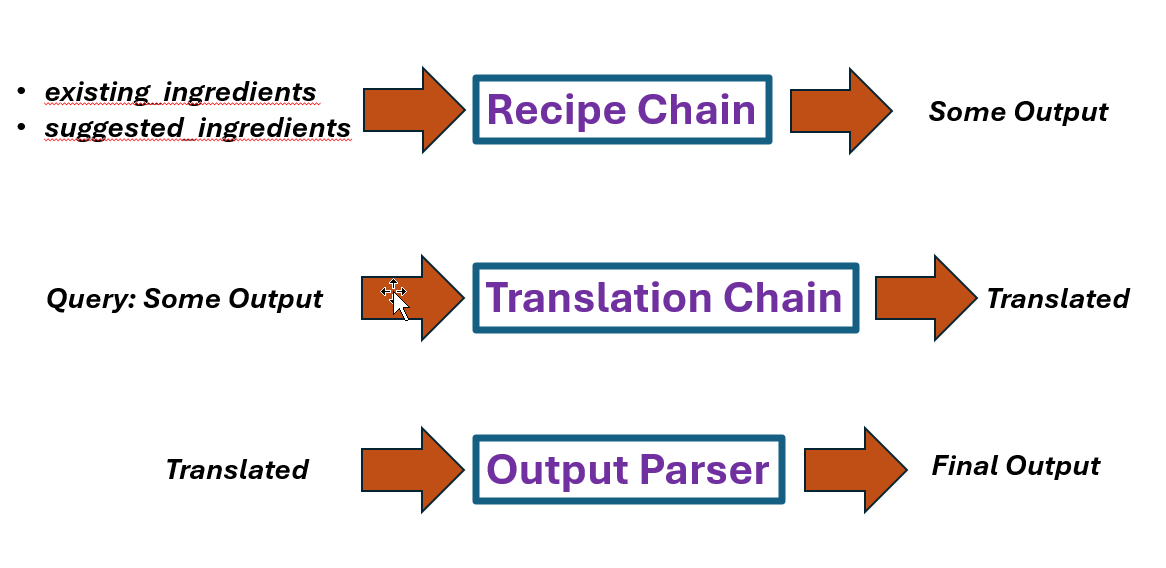

In [75]:
Image(filename= "tutorial/LLM+Langchain/Week-2/LCEL_1.png")

## Minimal Example

### 1. Creating a Prompt Template (創建提示模板):

- ChatPromptTemplate.from_template is used to create a prompt template. This template is a string that includes a placeholder {topic}.
- The template specifies the instruction: "tell me a short joke about {topic}".
- 使用 ChatPromptTemplate.from_template 創建一個提示模板。這個模板是一個包含佔位符 {topic} 的字符串。
- 模板指定了指令：“tell me a short joke about {topic}”（給我講一個關於{topic}的簡短笑話）。

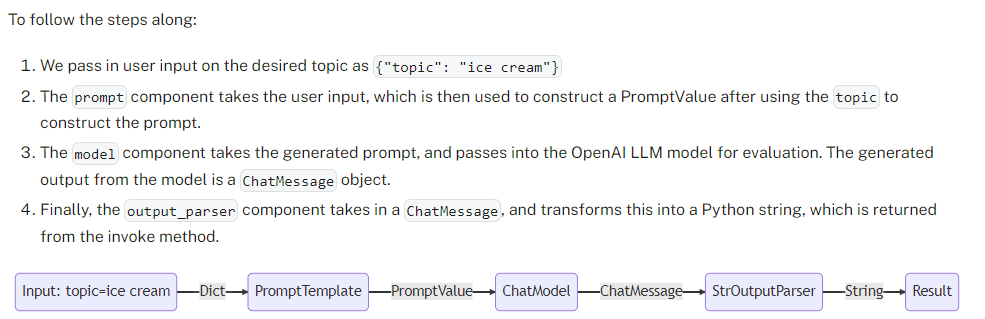

In [76]:
## Official diagram flow

Image(filename= "tutorial/LLM+Langchain/Week-2/lcel pipeline.png")

In [77]:
prompt = ChatPromptTemplate.from_template("tell me a short joke about {topic}")

In [78]:
prompt

ChatPromptTemplate(input_variables=['topic'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['topic'], input_types={}, partial_variables={}, template='tell me a short joke about {topic}'), additional_kwargs={})])

### 2. Setting Up the Chain (設置鏈條):

- chain = prompt | model sets up a chain where the prompt is connected to a model. This means that the model will process the prompt to generate a response.
- The | operator is used to combine the prompt and the model into a single chain.
- chain = prompt | model 設置了一個鏈條，其中提示連接到模型。這意味著模型將處理該提示來生成回應。
- | 運算符用於將提示和模型組合成一個鏈條。

In [79]:
# from the PromptTemplate to the ChatModel

chain = prompt | model

### 3. Getting the Joke (獲取笑話):

- The result of chain.invoke({"topic": "ice cream"}) is stored in the variable joke.
- This variable now contains the generated joke about ice cream.
- chain.invoke({"topic": "ice cream"}) 的結果存儲在變量 joke 中。
- 這個變量現在包含生成的關於冰淇淋的笑話。

In [80]:
# input -> prompt template -> model

joke = chain.invoke({"topic": "ice cream"})

In [81]:
joke

AIMessage(content='Why did the ice cream cone break up with the sundae? \n\nBecause it found someone cooler! 🍦', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 15, 'total_tokens': 37, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_6fc10e10eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-21b77276-0321-4542-acbf-d339ab277e9c-0')

In [82]:
joke.content

'Why did the ice cream cone break up with the sundae? \n\nBecause it found someone cooler! 🍦'

In [83]:
print(joke.content)

Why did the ice cream cone break up with the sundae? 

Because it found someone cooler! 🍦


### 1. Importing StrOutputParser (導入 StrOutputParser):

- The code imports StrOutputParser from the langchain_core.output_parsers module. This class is used to parse the output of the model into a string format.
- 代碼從 langchain_core.output_parsers 模塊導入 StrOutputParser。這個類用於將模型的輸出解析為字符串格式。

### 2. Creating an Output Parser:

- An instance of StrOutputParser is created and assigned to the variable output_parser.
- This parser will be used to process the raw output from the model and convert it into a readable string format.
- 創建一個 StrOutputParser 的實例，並將其賦值給變量 output_parser。
- 這個解析器將用於處理來自模型的原始輸出，並將其轉換為可讀的字符串格式。

In [85]:
from langchain_core.output_parsers import StrOutputParser

output_parser = StrOutputParser()

chain = prompt | model | output_parser

# input -> prompt template -> model -> output parser

chain.invoke({"topic": "ice cream"})

'Why did the ice cream cone break up with the sundae? \n\nBecause it found someone cooler!'

## 範例操作

### Coercion

Do not ask me why this word is used....

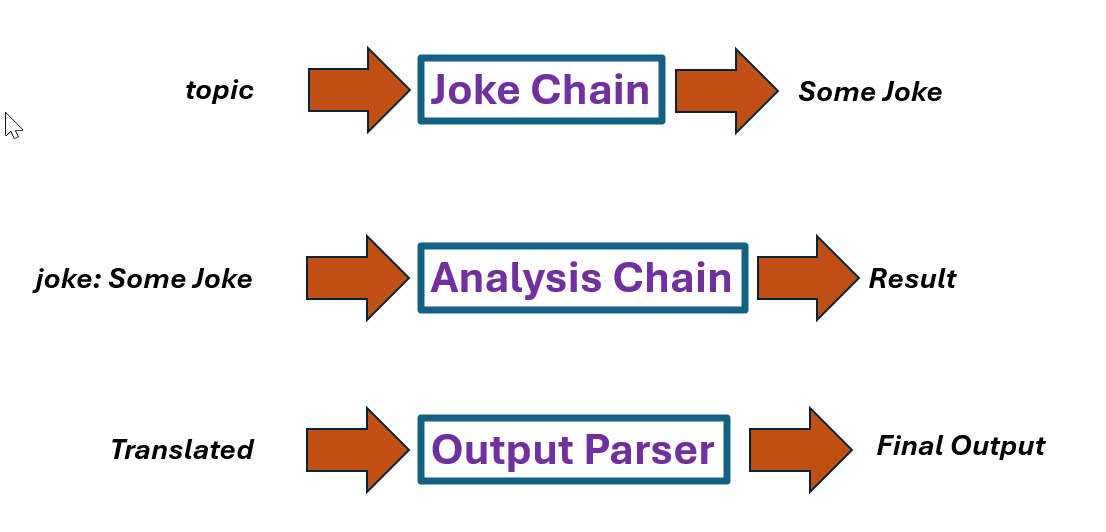

In [84]:
Image(filename= "tutorial/LLM+Langchain/Week-2/LCEL_2.png")

In [88]:
joke_chain = prompt | model | output_parser

template = """
           is this a funny joke? {joke}
           """

human_prompt = PromptTemplate(template=template,
                              input_variables=['joke'])

human_message = HumanMessagePromptTemplate(prompt=human_prompt)

analysis_prompt = ChatPromptTemplate.from_messages([human_message])

analysis_chain = analysis_prompt | model

composed_chain = {"joke": joke_chain} | analysis_chain | output_parser

In [89]:
composed_chain.invoke({"topic": "ice cream"})

'Yes, that\'s a funny joke! It\'s a clever play on words with "cooler" referring to both temperature and someone being more appealing. The ice cream cone and sundae personification adds a cute touch, making it lighthearted and enjoyable. 🍦'

In [90]:
print(composed_chain.invoke({"topic": "ice cream"}))

Yes, that's a funny joke! It has a clever play on words with "cooler," which refers to both temperature and finding someone more appealing. It's light-hearted and perfect for a pun!


1. chain 執行結果，將結果放進'joke' 這個 key 裡
2. {"joke": content} 被送進analysis_prompt 中，等價於 analysis_prompt.invoke({"joke": content})
3. model 接收 analysis_prompt 產生的結果
4. output_parser 處理結果

## Parallelize steps

In [91]:
from langchain_core.runnables import RunnableParallel

joke_chain = ChatPromptTemplate.from_template("tell me a joke about {topic}") | model
poem_chain = ChatPromptTemplate.from_template("write a 2-line poem about {topic}") | model

map_chain = RunnableParallel(joke=joke_chain, poem=poem_chain)

map_chain.invoke({"topic": "bear"})

{'joke': AIMessage(content='Why do bears have hairy coats?\n\nBecause they look silly in sweaters!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 13, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_6fc10e10eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-dd6712ed-d717-43e6-9a89-e7cd93853e63-0'),
 'poem': AIMessage(content="In the forest's embrace, a bear roams free,  \nMajestic and mighty, a symbol of wild glee.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 15, 'total_tokens': 40, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': 

- Computation time

In [93]:
%%timeit

joke_chain.invoke({"topic": "bear"})

636 ms ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [94]:
%%timeit

poem_chain.invoke({"topic": "bear"})

907 ms ± 169 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [95]:
%%timeit

map_chain.invoke({"topic": "bear"})

768 ms ± 79.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


RunnableParallel are also useful for running independent processes in parallel, since each Runnable in the map is executed in parallel. For example, we can see our earlier joke_chain, poem_chain and map_chain all have about the same runtime, even though map_chain executes both of the other two.



## Run custom function

In [96]:
from operator import itemgetter

from langchain_core.runnables import RunnableLambda


def length_function(text):
    return len(text)


def _multiple_length_function(text1, text2):
    return len(text1) * len(text2)


def multiple_length_function(_dict):
    return _multiple_length_function(_dict["text1"], _dict["text2"])

prompt = ChatPromptTemplate.from_template("what is {a} + {b}")

chain = (
    {
        "a": itemgetter("foo") | length_function,
        "b": {"text1": itemgetter("foo"), "text2": itemgetter("bar")}
        | multiple_length_function,
    }
    | prompt
    | model
)

TypeError: unsupported operand type(s) for |: 'operator.itemgetter' and 'function'

- Oops, how to solve this error message? 

In [97]:
# wrap the function with RunnableLambda

chain = (
    {
        "a": itemgetter("foo") | RunnableLambda(length_function),
        "b": {"text1": itemgetter("foo"), "text2": itemgetter("bar")}
        | RunnableLambda(multiple_length_function),
    }
    | prompt
    | model
)


In [98]:
chain.invoke({"foo": "bar", "bar": "gah"})

AIMessage(content='3 + 9 equals 12.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 14, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_6fc10e10eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-039afd33-974a-4430-86a5-9b55a697aa70-0')

How does it work?

- 'bar' -> foo, foo ('bar') -> length_function => a = 3
- 'bar' -> foo & 'gah' -> bar, foo ('bar') -> 'text1' & bar ('gah') -> 'text2', {'text1': 'bar', 'text2': 'gah'} -> multiple_length_function => b = 9
- {'a':3, 'b': 9} -> prompt -> 'what is 3 + 9'

#### Decorator

- Something very cool
- This is a new discovery in the beginning of December. So it is not used in subsequent tutorials. But feel free to adapt the code to experience the magic.
- Knowing of programming is still the key to successful AI application:

  you can only get a frog from a frog - Joerg Schmalian

In [99]:
from operator import itemgetter
from langchain_core.runnables import chain, RunnableParallel

prompt = ChatPromptTemplate.from_template("what is {a} + {b}")

@chain
def length_function(text):
    return len(text)

def _multiple_length_function(text1, text2):
    return len(text1) * len(text2)

@chain
def multiple_length_function(_dict):
    return _multiple_length_function(_dict["text1"], _dict["text2"])

chain = RunnableParallel(
        a=itemgetter("foo") | length_function,
        b={"text1": itemgetter("foo"), "text2": itemgetter("bar")}
        | multiple_length_function)| prompt | model

chain.invoke({"foo": "bar", "bar": "gah"})

AIMessage(content='3 + 9 equals 12.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 14, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_39a40c96a0', 'finish_reason': 'stop', 'logprobs': None}, id='run-da3b2e9d-62a6-43d4-a46f-9dc5a2b4447a-0')

## Passing data through

In [100]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

runnable = RunnableParallel(
    passed=RunnablePassthrough(),
    modified=lambda x: x["num"] + 1,
)

runnable.invoke({"num": 1})

{'passed': {'num': 1}, 'modified': 2}

In [101]:
runnable = RunnableParallel(
    passed_2=RunnablePassthrough(),
    modified=lambda x: x["num"] + 1,
)

runnable.invoke({"num": 1})

{'passed_2': {'num': 1}, 'modified': 2}

### Retrieval Example: Step by Step

### 1. Creating a Template (創建模板):

- A template is created that instructs the model to answer a question based only on a provided context. The template looks like this:
- 創建一個模板，指示模型僅基於提供的上下文來回答問題。模板如下

In [102]:
# context: something that will be generated with the question
# question

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

### 2. Generating a Prompt (生成提示):

- The ChatPromptTemplate.from_template(template) command uses the template to create a prompt that can later be filled with specific context and a question.
- 使用 ChatPromptTemplate.from_template(template) 命令來創建一個提示，之後可以用特定的上下文和問題來填充。

In [103]:
human_prompt = PromptTemplate(template=template,
                              input_variables=['context', 'question'])

human_message = HumanMessagePromptTemplate(prompt=human_prompt)

prompt_template = ChatPromptTemplate.from_messages([human_message])

### 3. Formulating a Query (制定查詢):

- A query is created by joining the ingredients from the 6th recipe in recipe_test with commas. This query is used to retrieve relevant information.
- 通過將 recipe_test 中第六個食譜的成分用逗號連接來創建查詢。此查詢用於檢索相關信息。

In [104]:
query = ", ".join(recipe_test[5]['ingredients'])

### 4. Retrieving Context (檢索上下文):

- The retriever.invoke(query) command uses the query to find the most relevant documents or information. This retrieved information is stored in the context variable.
- 使用 retriever.invoke(query) 命令，通過查詢找到最相關的文檔或信息。這些檢索到的信息存儲在 context 變量中。

In [105]:
context = retriever.invoke(query)

In [106]:
context

[Document(metadata={'cuisine': 'mexican', 'id': 539}, page_content='black beans, black pepper, jalapeno chilies, salt, sour cream, avocado, picante sauce, chili powder, frozen corn, cumin, brown rice, cilantro leaves, bay leaf, green chile, shredded cheddar cheese, vegetable broth, garlic cloves'),
 Document(metadata={'cuisine': 'mexican', 'id': 27521}, page_content='kosher salt, lean ground beef, onions, chili powder, garlic, salsa verde, cilantro, sugar, lime wedges, corn tortillas'),
 Document(metadata={'cuisine': 'italian', 'id': 1277}, page_content='frozen chopped spinach, garlic powder, green onions, fresh parsley, large egg whites, cooking spray, part-skim ricotta cheese, manicotti shells, fresh parmesan cheese, garlic, dried oregano, part-skim mozzarella cheese, 2% low-fat cottage cheese, lemon pepper'),
 Document(metadata={'cuisine': 'mexican', 'id': 8489}, page_content='flour tortillas, salsa, black beans, chili powder, shredded Monterey Jack cheese, tomatoes, green onions, r

### 5. Filling the Prompt (填充提示):

- The prompt is filled with the retrieved context and the question using prompt.invoke({"context": context, "question": question}). This creates an input prompt for the model.
- 使用 prompt.invoke({"context": context, "question": question}) 將提示填充檢索到的上下文和問題。這創建了模型的輸入提示。

In [107]:
question = "Show me all the ingredients."

In [108]:
prompt = prompt_template.invoke({"context": context, "question": question})

In [109]:
prompt

ChatPromptValue(messages=[HumanMessage(content="Answer the question based only on the following context:\n[Document(metadata={'cuisine': 'mexican', 'id': 539}, page_content='black beans, black pepper, jalapeno chilies, salt, sour cream, avocado, picante sauce, chili powder, frozen corn, cumin, brown rice, cilantro leaves, bay leaf, green chile, shredded cheddar cheese, vegetable broth, garlic cloves'), Document(metadata={'cuisine': 'mexican', 'id': 27521}, page_content='kosher salt, lean ground beef, onions, chili powder, garlic, salsa verde, cilantro, sugar, lime wedges, corn tortillas'), Document(metadata={'cuisine': 'italian', 'id': 1277}, page_content='frozen chopped spinach, garlic powder, green onions, fresh parsley, large egg whites, cooking spray, part-skim ricotta cheese, manicotti shells, fresh parmesan cheese, garlic, dried oregano, part-skim mozzarella cheese, 2% low-fat cottage cheese, lemon pepper'), Document(metadata={'cuisine': 'mexican', 'id': 8489}, page_content='flou

### 6. Getting the Model's Response (獲取模型的回應):

- The model is invoked with the filled prompt using model.invoke(prompt_as_input). The model processes the prompt and generates an output.
- 使用 model.invoke(prompt_as_input) 調用模型。模型處理提示並生成輸出。

In [111]:
output = model.invoke(prompt)

In [112]:
print(output.content)

Here are all the ingredients listed in the provided context:

1. Black beans
2. Black pepper
3. Jalapeno chilies
4. Salt
5. Sour cream
6. Avocado
7. Picante sauce
8. Chili powder
9. Frozen corn
10. Cumin
11. Brown rice
12. Cilantro leaves
13. Bay leaf
14. Green chile
15. Shredded cheddar cheese
16. Vegetable broth
17. Garlic cloves
18. Kosher salt
19. Lean ground beef
20. Onions
21. Salsa verde
22. Sugar
23. Lime wedges
24. Corn tortillas
25. Frozen chopped spinach
26. Garlic powder
27. Green onions
28. Fresh parsley
29. Large egg whites
30. Cooking spray
31. Part-skim ricotta cheese
32. Manicotti shells
33. Fresh parmesan cheese
34. Dried oregano
35. Part-skim mozzarella cheese
36. 2% low-fat cottage cheese
37. Lemon pepper
38. Flour tortillas
39. Salsa
40. Shredded Monterey Jack cheese
41. Tomatoes
42. Red bell pepper
43. White cheddar cheese
44. Cayenne pepper
45. Garlic powder
46. Red pepper flakes
47. Onion powder
48. Oregano
49. Smoked paprika
50. Cauliflower
51. Reduced-sodium t

### 7. Parsing the Output (解析輸出):

- The output from the model is parsed using output_parser.parse(output.content). This ensures the output is in a readable format.
- 使用 output_parser.parse(output.content) 解析模型的輸出。這確保輸出是可讀的格式。

In [115]:
print(output_parser.parse(output.content))

Here are all the ingredients listed in the provided context:

1. Black beans
2. Black pepper
3. Jalapeno chilies
4. Salt
5. Sour cream
6. Avocado
7. Picante sauce
8. Chili powder
9. Frozen corn
10. Cumin
11. Brown rice
12. Cilantro leaves
13. Bay leaf
14. Green chile
15. Shredded cheddar cheese
16. Vegetable broth
17. Garlic cloves
18. Kosher salt
19. Lean ground beef
20. Onions
21. Salsa verde
22. Sugar
23. Lime wedges
24. Corn tortillas
25. Frozen chopped spinach
26. Garlic powder
27. Green onions
28. Fresh parsley
29. Large egg whites
30. Cooking spray
31. Part-skim ricotta cheese
32. Manicotti shells
33. Fresh parmesan cheese
34. Dried oregano
35. Part-skim mozzarella cheese
36. 2% low-fat cottage cheese
37. Lemon pepper
38. Flour tortillas
39. Salsa
40. Shredded Monterey Jack cheese
41. Tomatoes
42. Red bell pepper
43. White cheddar cheese
44. Cayenne pepper
45. Garlic powder
46. Red pepper flakes
47. Onion powder
48. Oregano
49. Smoked paprika
50. Cauliflower
51. Reduced-sodium t

In [116]:
from langchain_core.runnables import RunnablePassthrough

chain = RunnablePassthrough.assign(
    context=itemgetter("query")|retriever) | prompt_template | model | output_parser

chain.invoke({"query": query, "question": question})

'Here are all the ingredients listed in the context:\n\n1. Black beans\n2. Black pepper\n3. Jalapeno chilies\n4. Salt\n5. Sour cream\n6. Avocado\n7. Picante sauce\n8. Chili powder\n9. Frozen corn\n10. Cumin\n11. Brown rice\n12. Cilantro leaves\n13. Bay leaf\n14. Green chile\n15. Shredded cheddar cheese\n16. Vegetable broth\n17. Garlic cloves\n18. Kosher salt\n19. Lean ground beef\n20. Onions\n21. Salsa verde\n22. Sugar\n23. Lime wedges\n24. Corn tortillas\n25. Frozen chopped spinach\n26. Garlic powder\n27. Green onions\n28. Fresh parsley\n29. Large egg whites\n30. Cooking spray\n31. Part-skim ricotta cheese\n32. Manicotti shells\n33. Fresh parmesan cheese\n34. Dried oregano\n35. Part-skim mozzarella cheese\n36. 2% low-fat cottage cheese\n37. Lemon pepper\n38. Flour tortillas\n39. Salsa\n40. Shredded Monterey Jack cheese\n41. Tomatoes\n42. Red bell pepper\n43. White cheddar cheese\n44. Cayenne pepper\n45. Garlic powder\n46. Red pepper flakes\n47. Onion powder\n48. Oregano\n49. Smoked pa

## Translation Template

In [ ]:
def translation_function(text):

    """
    翻譯
    直接將給予內容text翻譯成繁體中文
    """
    
    system_template = """
                      You are a helpful AI assistant with native speaker 
                      fluency in both English and traditional Chinese 
                      (繁體中文). You will translate the given content.
                      """)

    human_template = """
                     {query}
                     """

    input_ = {"system": {"template": system_template},
              "human": {"template": human_template,
                        "input_variable": ["query"]}}
    
    prompt_template = build_standard_chat_prompt_template(input_)

    chain = prompt_template|model
    
    output = chain.invoke({"query": text})
    return output.output

In [ ]:
# https://www.loreal-paris.ru/revitalift-filler/syvorotka-dlya-lica-i-shei-s-15-chistoj-gialuronovoj-kisloty-protiv-morshchin

chain.invoke({"product": """
                         Сыворотка Ревиталифт Филлер для лица и шеи с 1,5% 
                         чистой гиалуроновой кислотой
                         """})

In [ ]:
chain.invoke({"product": 'Felt Liner Noir Infaillible Grip Precision'})

## 回家作業

1. 根據食譜 - LCEL, 配合LCEL, 完成從給 材料 -> 中文食譜
2. 根據 retrieval example -> 要求將食材分類 (肉，香料，奶製品，等等)